# DO ZROBIENIA
- dodać kolumnę model z nazwą modelu oh encoding
- sprawdzić jak sprawdza się propozycja ramki norberta

In [3]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score

from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN

from sklearn.manifold import TSNE

In [4]:
data = pd.read_csv("../../data/modelers_data.csv")

In [5]:
# podmiana złej rozdzielczości
mask = data.resolution_width <= data.resolution_height
data.loc[mask,["resolution_width","resolution_height"]] = data.loc[mask,["resolution_height","resolution_width"]].values


In [21]:
data.loc[data.resolution_width <= data.resolution_height]

,index,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,secondary_storage_type,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty


In [22]:
data.head(3)

,index,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,secondary_storage_type,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty
0,949,msi,MSI Modern 15 B7M-072IN Laptop (Ryzen 5 7530U/...,43990,53,amd,ryzen 5,6,12,8,...,No secondary storage,0,amd,integrated,False,15.6,1920,1080,windows,1
1,584,msi,MSI Prestige 16 A13UCX-250IN Laptop (13th Gen ...,119990,73,intel,core i7,14,20,16,...,No secondary storage,0,nvidia,dedicated,False,16.0,2560,1600,windows,2
2,937,acer,Acer Aspire 7 A715-75G Gaming Laptop (10th Gen...,45990,59,intel,core i5,4,8,8,...,No secondary storage,0,nvidia,dedicated,False,15.6,1920,1080,windows,1


In [7]:
#   Column                      Non-Null Count  Dtype       Nulls                  Kodowanie                                   Blady
# ---  ------                      --------------  -----    -------                -------                                     ------
#  1   brand                       693 non-null    object                           grupowanie,
#  2   Model                       693 non-null    object   useless                 odrzucic
#  3   Price                       693 non-null    int64   
#  4   Rating                      693 non-null    int64  
#  5   processor_brand             693 non-null    object   other                   oh
#  6   processor_tier              693 non-null    object   other                   numerycznie
#  7   num_cores                   693 non-null    int64  
#  8   num_threads                 693 non-null    int64  
#  9   ram_memory                  693 non-null    int64  
#  10  primary_storage_type        693 non-null    object                           oh,bin ?             676/17
#  11  primary_storage_capacity    693 non-null    int64  
#  12  secondary_storage_type      693 non-null    object   No secondary storage    oh,bin ? odrzucic, bo mamy secondary_storage_capacity==0   10/683
#  13  secondary_storage_capacity  693 non-null    int64  
#  14  gpu_brand                   693 non-null    object                           oh
#  15  gpu_type                    693 non-null    object                           apple ma apple, reszta binary
#  16  is_touch_screen             693 non-null    bool   
#  17  display_size                693 non-null    float64
#  18  resolution_width            693 non-null    int64  
#  19  resolution_height           693 non-null    int64                                                                       6 recordow ma większe rh od rw (to są bledy)
#  20  OS                          693 non-null    object   other                   oh , stosunek windowsa do reszty 647/46
#  21  year_of_warranty            693 non-null    object   No information          numerycznie, kolumna na brak informacji

# Preprocessing

 KTÓRE KOLUMNY POWINNY ZACHOWAĆ NIEZMIENIONE WARTOŚCI??? KTÓRYCH NIE TYKAMY ???

In [23]:
data_copy = data.copy()

In [24]:
# oh dla []'processor_brand','OS','gpu_brand','gpu_type'] oraz dla brand ,ale tylko 6 najczęstszych wartości
diff1 = pd.get_dummies(data_copy[['processor_brand','OS','gpu_brand','gpu_type']],dtype='int')
brands_to_keep = ['hp' , 'lenovo' , 'asus','dell','msi','acer','apple']
data_copy['brand'] = data_copy['brand'].apply(lambda x: x if x in brands_to_keep else 'other')
diff2 = pd.get_dummies(data_copy[['brand']],dtype='int')
data_copy_2 = data_copy.copy()
data_copy_2 = data_copy_2.drop(['index','Model','brand','OS','processor_brand','processor_tier','gpu_brand','gpu_type'],axis=1)
df1 = pd.concat([data_copy_2,diff1,diff2],axis=1)
df1.is_touch_screen = df1.is_touch_screen + 0
df1.primary_storage_type = (df1.primary_storage_type=='SSD') + 0


In [25]:
df1.head(2)

,Price,Rating,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,secondary_storage_type,secondary_storage_capacity,is_touch_screen,...,gpu_type_dedicated,gpu_type_integrated,brand_acer,brand_apple,brand_asus,brand_dell,brand_hp,brand_lenovo,brand_msi,brand_other
0,43990,53,6,12,8,1,512,No secondary storage,0,0,...,0,1,0,0,0,0,0,0,1,0
1,119990,73,14,20,16,1,1024,No secondary storage,0,0,...,1,0,0,0,0,0,0,0,1,0


# Rozkład ceny

Zarówno TSNE jak i DBSCAN działają inaczej po użyciuu log() na kolumnie z cenami

Text(0.5, 1.0, 'Rozkład log(price)')

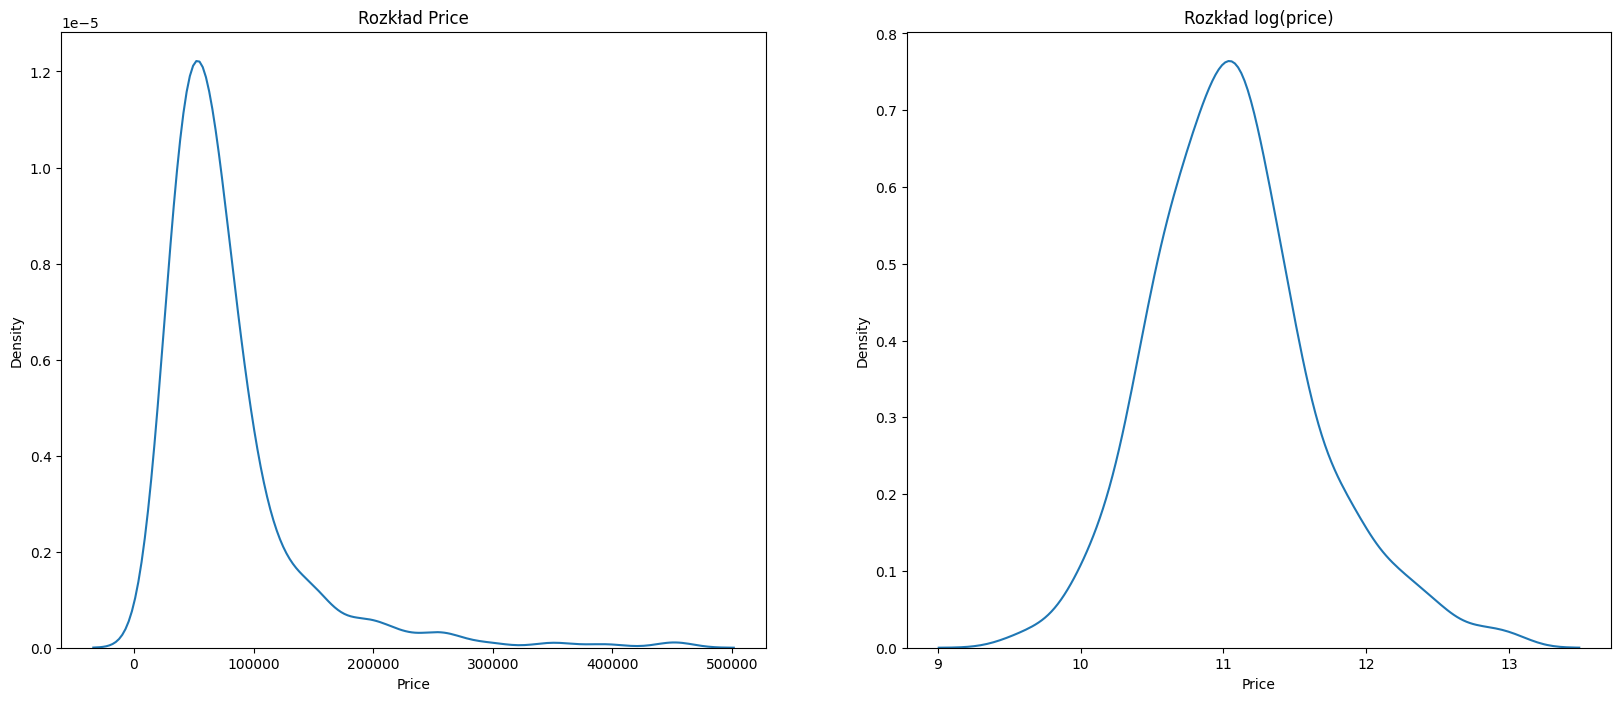

In [26]:
figure,ax = plt.subplots(1,2,figsize=(20,8))
ax = ax.flatten()
sns.kdeplot(x=data.Price,ax=ax[0])
ax[0].set_title("Rozkład Price")
sns.kdeplot(x=np.log(data.Price),ax=ax[1])
ax[1].set_title("Rozkład log(price)")


# Processor Tier

In [27]:
data.processor_tier.value_counts()

processor_tier
core i5         231
core i7         113
ryzen 5         100
core i3          95
ryzen 7          59
celeron          25
core i9          23
ryzen 3          21
ryzen 9           8
other             7
m3                6
m2                3
core ultra 7      1
pentium           1
Name: count, dtype: int64

In [13]:
# ryzen x == core ix
# celeron == core i3
# m1 == core i5
# m2 == core i7
# core ultra 7 == core i7 | core i9 ?
# pentium == core i5

In [28]:
A = data.processor_tier
A[A=='celeron'] = 'core i3'
A[A=='pentium'] = 'core i5'
A[A=='m1'] = 'core i5'
A[A=='m2'] = 'core i7'
mask_other_processor_tier = A=='other'
A[A=='other'] = '0'
A = A.apply(lambda x : int(re.findall(r'\d+', x)[0]))

C:\Users\jancw\AppData\Local\Temp\ipykernel_18636\2374467150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='celeron'] = 'core i3'
C:\Users\jancw\AppData\Local\Temp\ipykernel_18636\2374467150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='pentium'] = 'core i5'
C:\Users\jancw\AppData\Local\Temp\ipykernel_18636\2374467150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='m1'] = 'core i5'
C:\Users\jancw\AppDat

In [29]:
df1['processor_tier'] = A
df1['processor_type_other'] = mask_other_processor_tier + 0

# year_of_warranty

In [30]:
mask_year_of_war_no =df1.year_of_warranty=='No information'
df1.loc[mask_year_of_war_no,['year_of_warranty']] = 0
df1['year_of_warranty'] = df1['year_of_warranty'].apply(lambda x : int(x))
df1['year_of_warranty_other'] = mask_year_of_war_no + 0

# secondary_storage_type

- opcja 1: zrezygnować z 'secondary_storage_type' na rzecz 'secondary_storage_capacity', bo ta kolumna wynosi 0 gdy nie ma drugiego dysku
- opcja 2: zostawić 'secondary_storage_type' i tam gdzie nie ma dawać 0

In [31]:
# opcja 1
df1 = df1.drop('secondary_storage_type',axis=1)
# opcja 2
# df1['secondary_storage_type'] = (df1['secondary_storage_type']=="HDD") + 0 

In [32]:
df1.head(2)

,Price,Rating,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,secondary_storage_capacity,is_touch_screen,display_size,...,brand_apple,brand_asus,brand_dell,brand_hp,brand_lenovo,brand_msi,brand_other,processor_tier,processor_type_other,year_of_warranty_other
0,43990,53,6,12,8,1,512,0,0,15.6,...,0,0,0,0,0,1,0,5,0,0
1,119990,73,14,20,16,1,1024,0,0,16.0,...,0,0,0,0,0,1,0,7,0,0


In [33]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Price                       693 non-null    int64  
 1   Rating                      693 non-null    int64  
 2   num_cores                   693 non-null    int64  
 3   num_threads                 693 non-null    int64  
 4   ram_memory                  693 non-null    int64  
 5   primary_storage_type        693 non-null    int32  
 6   primary_storage_capacity    693 non-null    int64  
 7   secondary_storage_capacity  693 non-null    int64  
 8   is_touch_screen             693 non-null    int32  
 9   display_size                693 non-null    float64
 10  resolution_width            693 non-null    int64  
 11  resolution_height           693 non-null    int64  
 12  year_of_warranty            693 non-null    int64  
 13  processor_brand_amd         693 non

In [34]:
df2 = df1.copy()
# df2['Price'] = np.log(df2['Price'] )
df2['Price'] = (df2['Price']-min(df2['Price']))/(max(df2['Price'])-min(df2['Price']))

df2['primary_storage_capacity'] = np.log2(df1.primary_storage_capacity)
df2['secondary_storage_capacity'] = df2['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
df2['resolution_width']  = np.log(df2.resolution_width)
df2['resolution_width'] = (df2['resolution_width']-min(df2['resolution_width']))/(max(df2['resolution_width'])-min(df2['resolution_width']))

df2['resolution_height'] = np.log(df2.resolution_height) 
df2['resolution_height'] = (df2['resolution_height']-min(df2['resolution_height']))/(max(df2['resolution_height'])-min(df2['resolution_height']))

df2['Rating'] = df2['Rating']/100
df2['display_size'] = (df2['display_size']-min(df2['display_size']))/(max(df2['display_size'])-min(df2['display_size']))

df2['processor_tier'] = (df2['processor_tier']-min(df2['processor_tier']))/(max(df2['processor_tier'])-min(df2['processor_tier']))
df2['num_cores'] = (df2['num_cores']-min(df2['num_cores']))/(max(df2['num_cores'])-min(df2['num_cores']))
df2['num_threads'] = (df2['num_threads']-min(df2['num_threads']))/(max(df2['num_threads'])-min(df2['num_threads']))
df2['ram_memory'] = (df2['ram_memory']-min(df2['ram_memory']))/(max(df2['ram_memory'])-min(df2['ram_memory']))
df2['primary_storage_capacity'] = (df2['primary_storage_capacity']-min(df2['primary_storage_capacity']))/(max(df2['primary_storage_capacity'])-min(df2['primary_storage_capacity']))
df2['secondary_storage_capacity'] = (df2['secondary_storage_capacity']-min(df2['secondary_storage_capacity']))/(max(df2['secondary_storage_capacity'])-min(df2['secondary_storage_capacity']))


C:\Users\jancw\AppData\Local\Temp\ipykernel_18636\3733991366.py:6: RuntimeWarning: divide by zero encountered in log2
  df2['secondary_storage_capacity'] = df2['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))


# Pierwsze modele

# Badanie optymalnego k

In [21]:
# funkcje do wykresów z zajęć
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=101)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

# A w praktyce wygląda to tak:
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k,random_state= 101)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores
    
def metrics_plots(X,max_k=10):

    score = []
    score_kmeans_s = []
    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state= 101)
        predictions = kmeans.fit_predict(X)
        # Calculate cluster validation metrics and append to lists of metrics
        score.append(kmeans.score(X))
        score_kmeans_s.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))
        score_kmeans_c.append(calinski_harabasz_score(X, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(X, predictions))

    list_scores = [score, score_kmeans_s, score_kmeans_c, score_kmeans_d] 
    # Elbow Method plot
    list_title = ['Within-cluster sum of squares', 'Silhouette Score', 'Calinski Harabasz', 'Davies Bouldin'] 
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

Text(0.5, 1.0, 'Metoda silhouette')

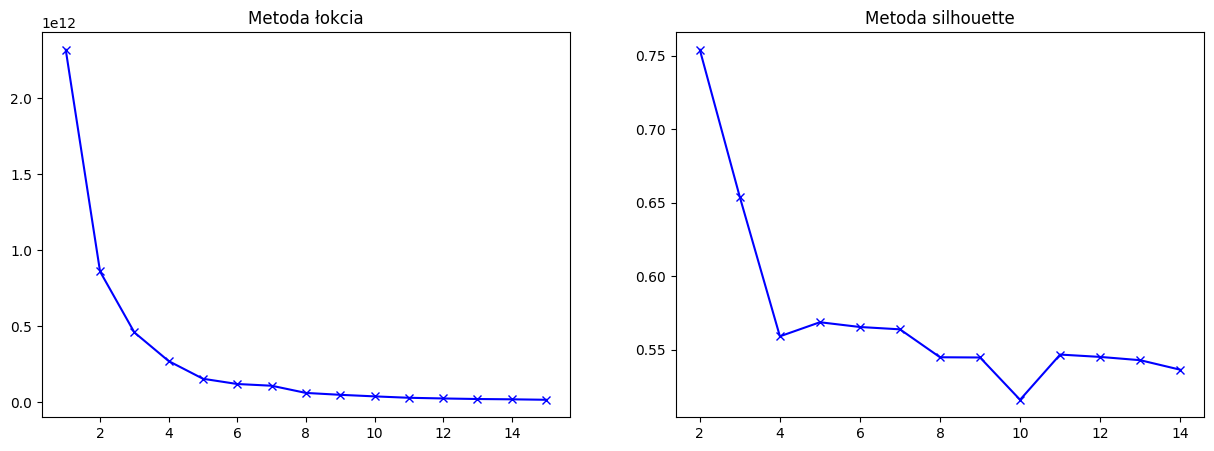

In [36]:
fig, axis = plt.subplots(1,2,figsize=(15,5))
wcss_vec = count_wcss_scores(df1, 15)
x_ticks = list(range(1, len(wcss_vec) + 1))
axis[0].plot(x_ticks, wcss_vec, 'bx-')
axis[0].set_title("Metoda łokcia")
cluster_num_seq = range(2, 15) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(df1, cluster_num_seq, KMeans, silhouette_score)
axis[1].plot(cluster_num_seq, silhouette_vec, 'bx-')
axis[1].set_title("Metoda silhouette")

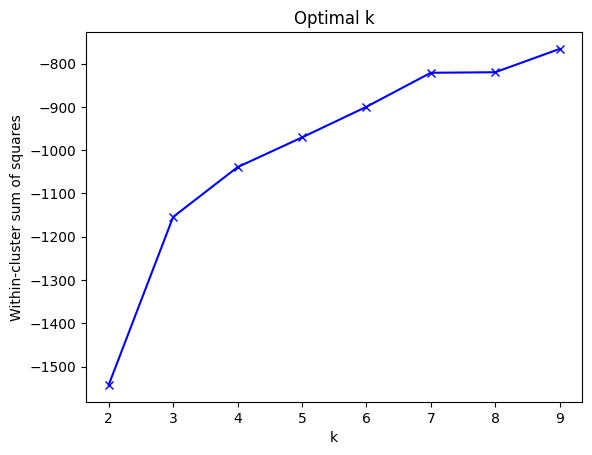

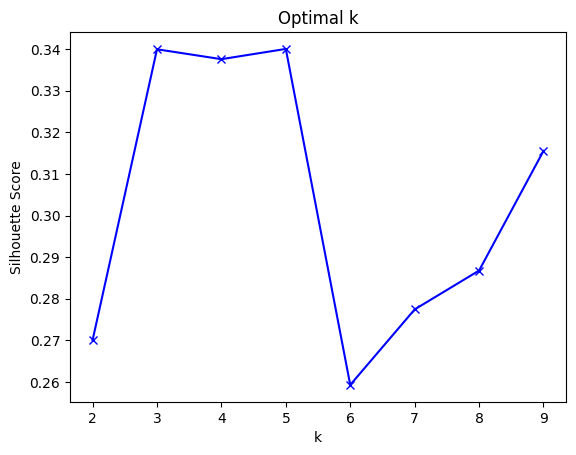

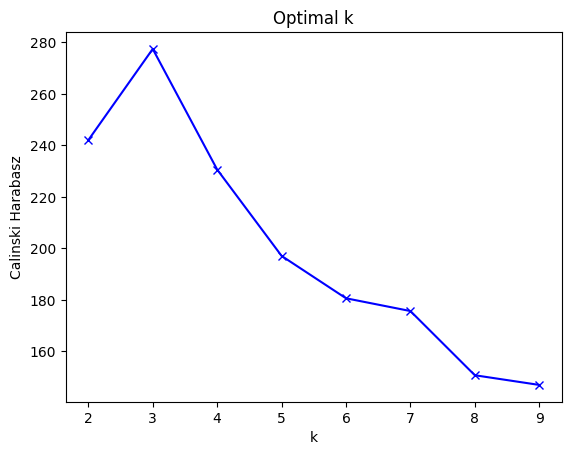

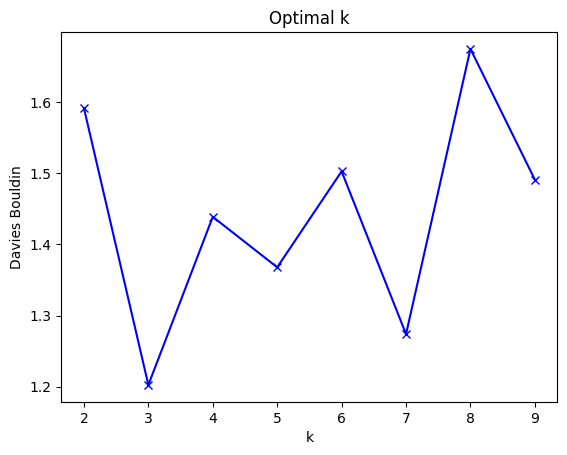

In [37]:
metrics_plots(df2,max_k=10)

# AgglomerativeClustering

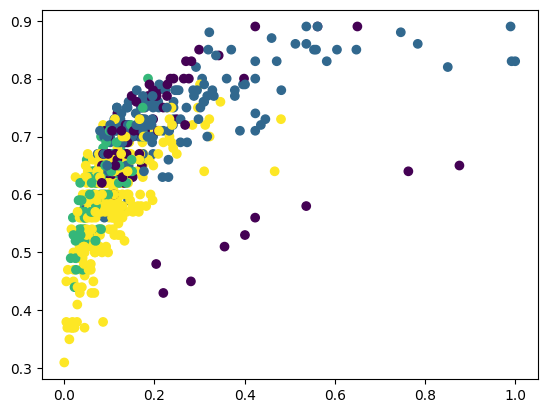

In [58]:
model_matrix = df2.values
model = AgglomerativeClustering(n_clusters=4)
y_aggc = model.fit_predict(model_matrix)
plt.scatter(model_matrix[:, 0], model_matrix[:, 1], c=y_aggc, cmap='viridis')
plt.show()

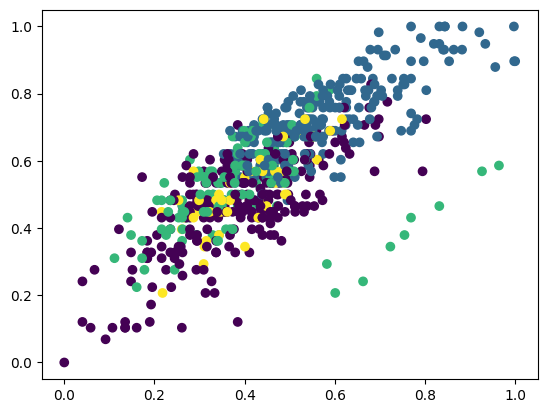

In [57]:
model_matrix = data_s.values
model = AgglomerativeClustering(n_clusters=4)
y_aggc_s = model.fit_predict(model_matrix)
plt.scatter(model_matrix[:, 0], model_matrix[:, 1], c=y_aggc_s, cmap='viridis')
plt.show()

In [36]:
model_matrix = df2.values
model_aggc_6 = AgglomerativeClustering(n_clusters=6)
model_aggc_5 = AgglomerativeClustering(n_clusters=5)
model_aggc_7 = AgglomerativeClustering(n_clusters=7)

y_aggc_6 = model_aggc_6.fit_predict(model_matrix)
y_aggc_5 = model_aggc_5.fit_predict(model_matrix)
y_aggc_7 = model_aggc_7.fit_predict(model_matrix)

# KMeans

c:\Users\jancw\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jancw\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


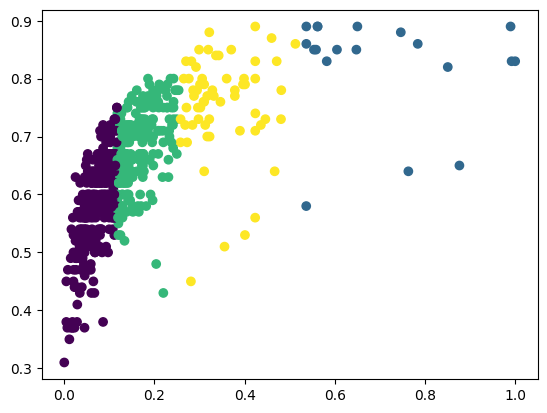

In [37]:
model_matrix = df2.values
model_kmeans = KMeans(n_clusters=4)
y_km = model_kmeans.fit_predict(df1)
plt.scatter(model_matrix[:, 0], model_matrix[:, 1], c=y_km, cmap='viridis')
# centers = model_kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
plt.show()

# DBSCAN 

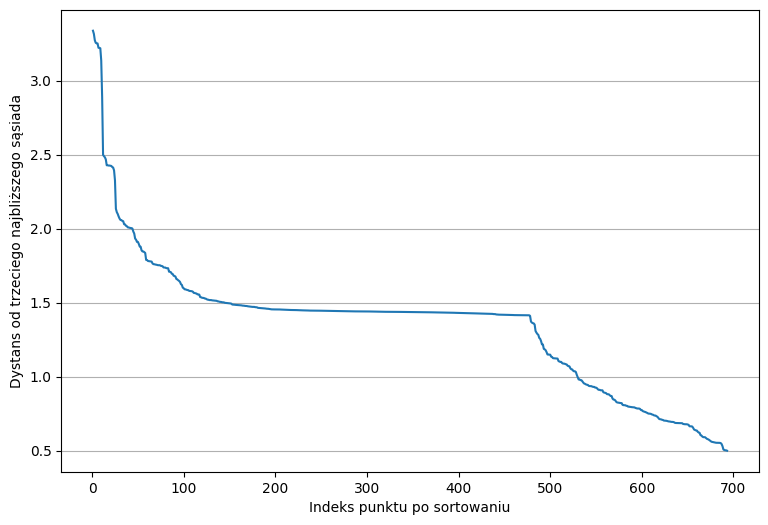

In [38]:
model_matrix = df2.values
minPts = model_matrix.shape[1]
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(model_matrix)
distances, indices = nbrs.kneighbors(model_matrix)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,model_matrix.shape[0]+1)), distanceDec)

# plt.xscale('log')
plt.grid(axis='y')

plt.show()

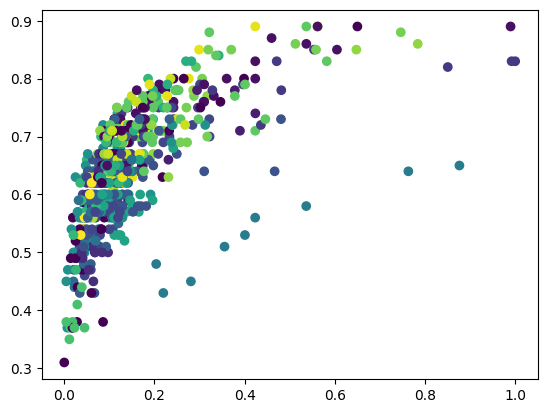

In [42]:
model_dbscan = DBSCAN(eps=1.41,min_samples=7)
y_dbscan = model_dbscan.fit_predict(model_matrix)
plt.scatter(model_matrix[:, 0], model_matrix[:, 1], c=y_dbscan, cmap='viridis')
plt.show()


# Gaussian Mixture Models

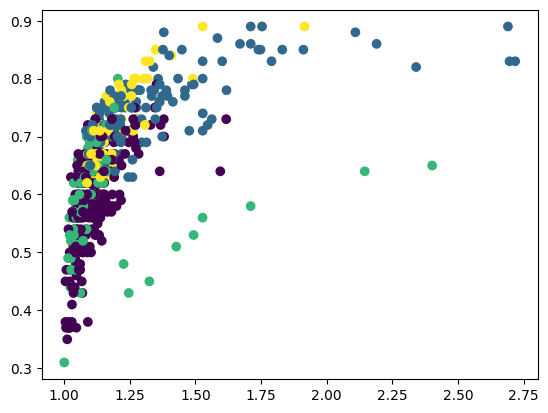

In [40]:
model_matrix = df2.values
model_gmm = mixture.GaussianMixture(n_components=4, covariance_type="full")
y_gmm = model_gmm.fit_predict(model_matrix)
plt.scatter(np.exp(model_matrix[:, 0]), model_matrix[:, 1], c=y_gmm, cmap='viridis')
plt.show()

In [41]:
model_gmm_5 = mixture.GaussianMixture(n_components=5, covariance_type="full")
model_gmm_7 = mixture.GaussianMixture(n_components=7, covariance_type="full")
model_gmm_6 = mixture.GaussianMixture(n_components=6, covariance_type="full")

y_gmm_5 = model_gmm_5.fit_predict(model_matrix)
y_gmm_7 = model_gmm_7.fit_predict(model_matrix)
y_gmm_6 = model_gmm_6.fit_predict(model_matrix)

# Wykresy wyników TSNE

# Inne pomysły na transformacje

dalej mamy parę kolumn ,których wartości przyjmują relatywnie duże wartości co w kontraście z 0,1 z ohencodingu może być niekorzystne:
 - primary_storage_capacity - log2
 - secondary_storage_capacity - log2
 - resolution_width - cos
 - resolution_height - cos
 - Price - log (NIE PODLEGA WĄTPLIWOŚCI ??)
 - Rating - przeskalować do [0,1]
 - display_size - cos

 KTÓRE KOLUMNY POWINNY ZACHOWAĆ NIEZMIENIONE WARTOŚCI???

1. primary_storage_capacity -> np.log2(df1.primary_storage_capacity)

Text(0.5, 1.0, 'Rozkład log(primary_storage_capacity)')

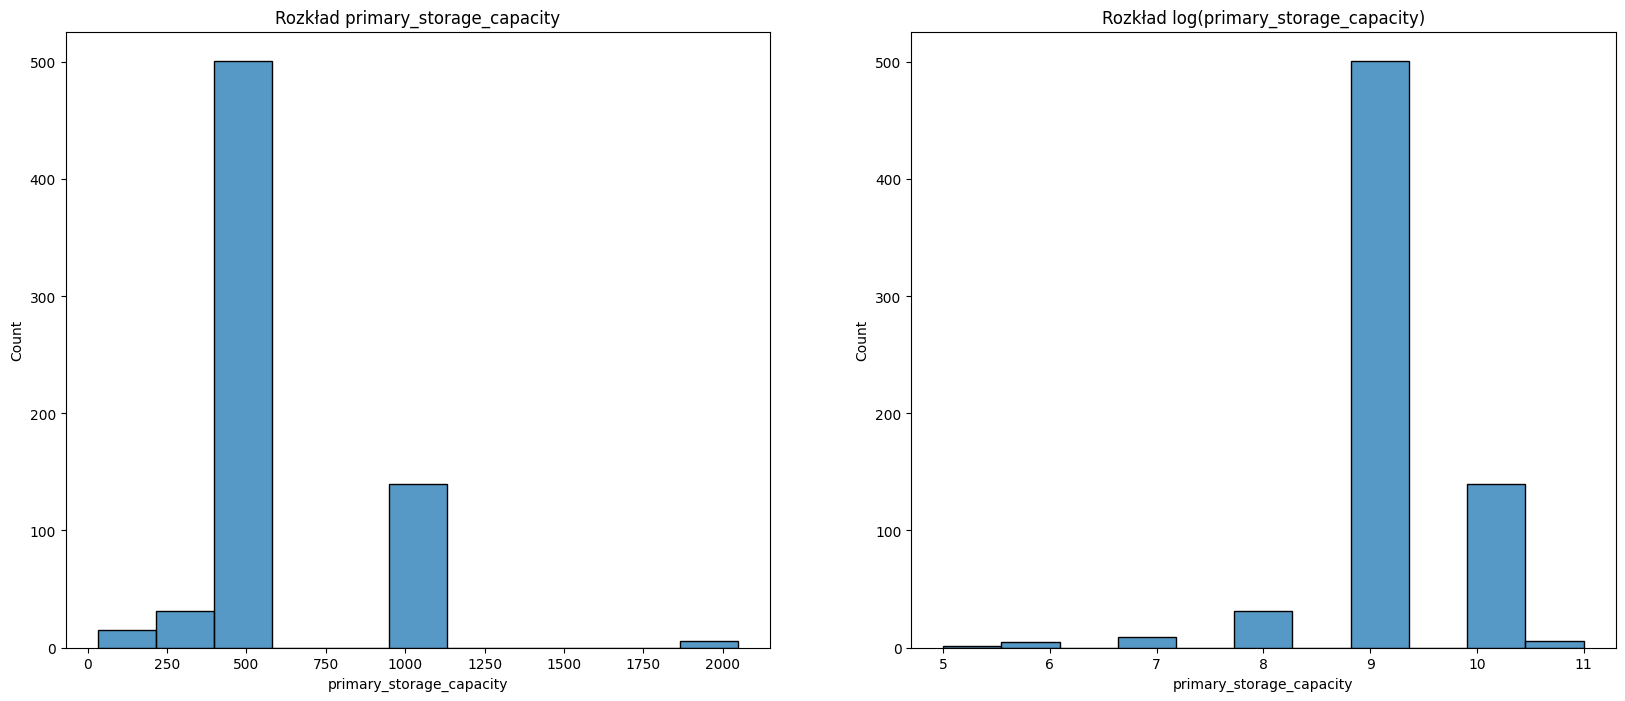

In [31]:
figure,ax = plt.subplots(1,2,figsize=(20,8))
ax = ax.flatten()
sns.histplot(x=df1.primary_storage_capacity,ax=ax[0])
ax[0].set_title("Rozkład primary_storage_capacity")
sns.histplot(x=np.log2(df1.primary_storage_capacity),ax=ax[1])
ax[1].set_title("Rozkład log(primary_storage_capacity)")


2. secondary_storage_capacity ->  np.log2(df1.primary_storage_capacity) i -inf na 0

3. resolution -> log

Text(0.5, 1.0, 'res height log')

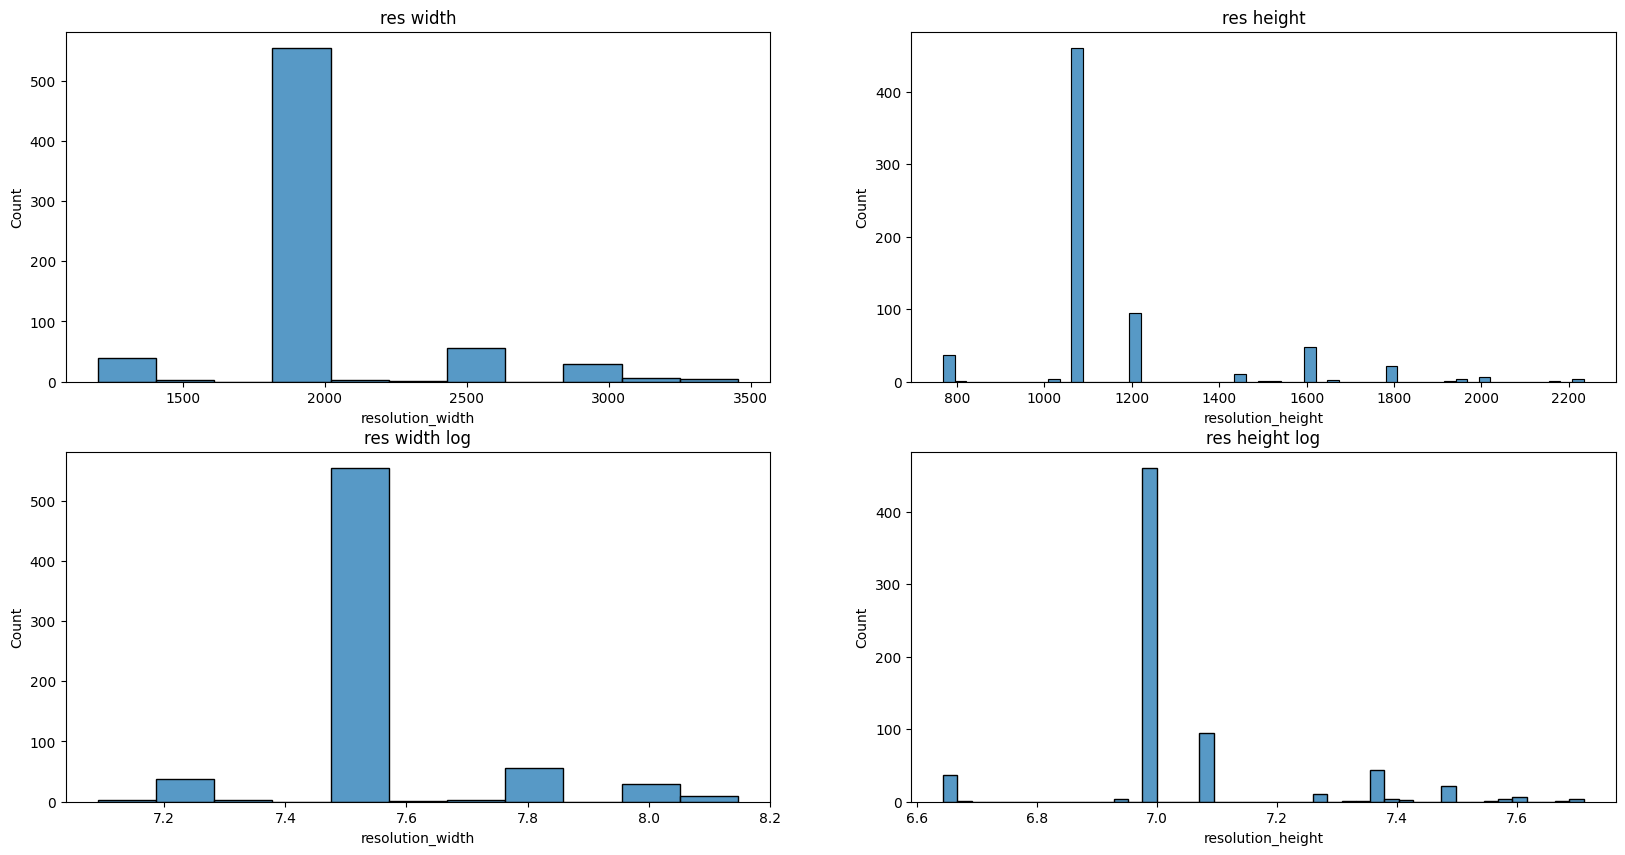

In [79]:
figure,ax = plt.subplots(2,2,figsize=(20,10))
ax = ax.flatten()
sns.histplot((df1.resolution_width),ax=ax[0])
sns.histplot((df1.resolution_height),ax=ax[1])
sns.histplot(np.log(df1.resolution_width),ax=ax[2])
sns.histplot(np.log(df1.resolution_height),ax=ax[3])
ax[0].set_title("res width")
ax[1].set_title("res height")
ax[2].set_title("res width log")
ax[3].set_title("res height log")

4. Rating -> do [0,1]

5. display_size -> cos

Text(0.5, 1.0, 'Rozkład log(primary_storage_capacity)')

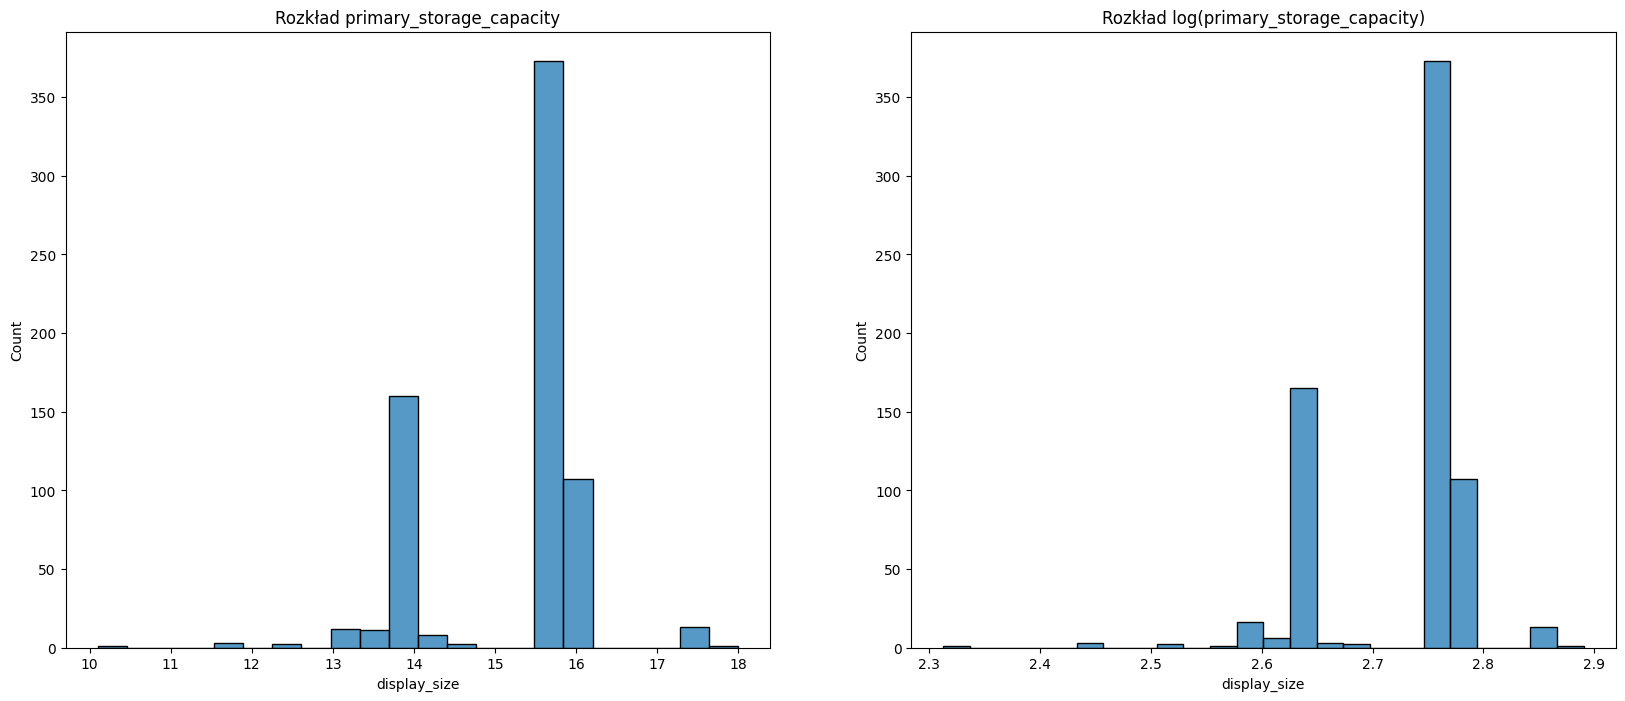

In [86]:
figure,ax = plt.subplots(1,2,figsize=(20,8))
ax = ax.flatten()
sns.histplot((df1.display_size),ax=ax[0])
ax[0].set_title("Rozkład primary_storage_capacity")
sns.histplot(np.log(df1.display_size),ax=ax[1])
ax[1].set_title("Rozkład log(primary_storage_capacity)")


# Wszystkie transformacje i do [0,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.524025
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.793068
[t-SNE] KL divergence after 3750 iterations: 0.163446


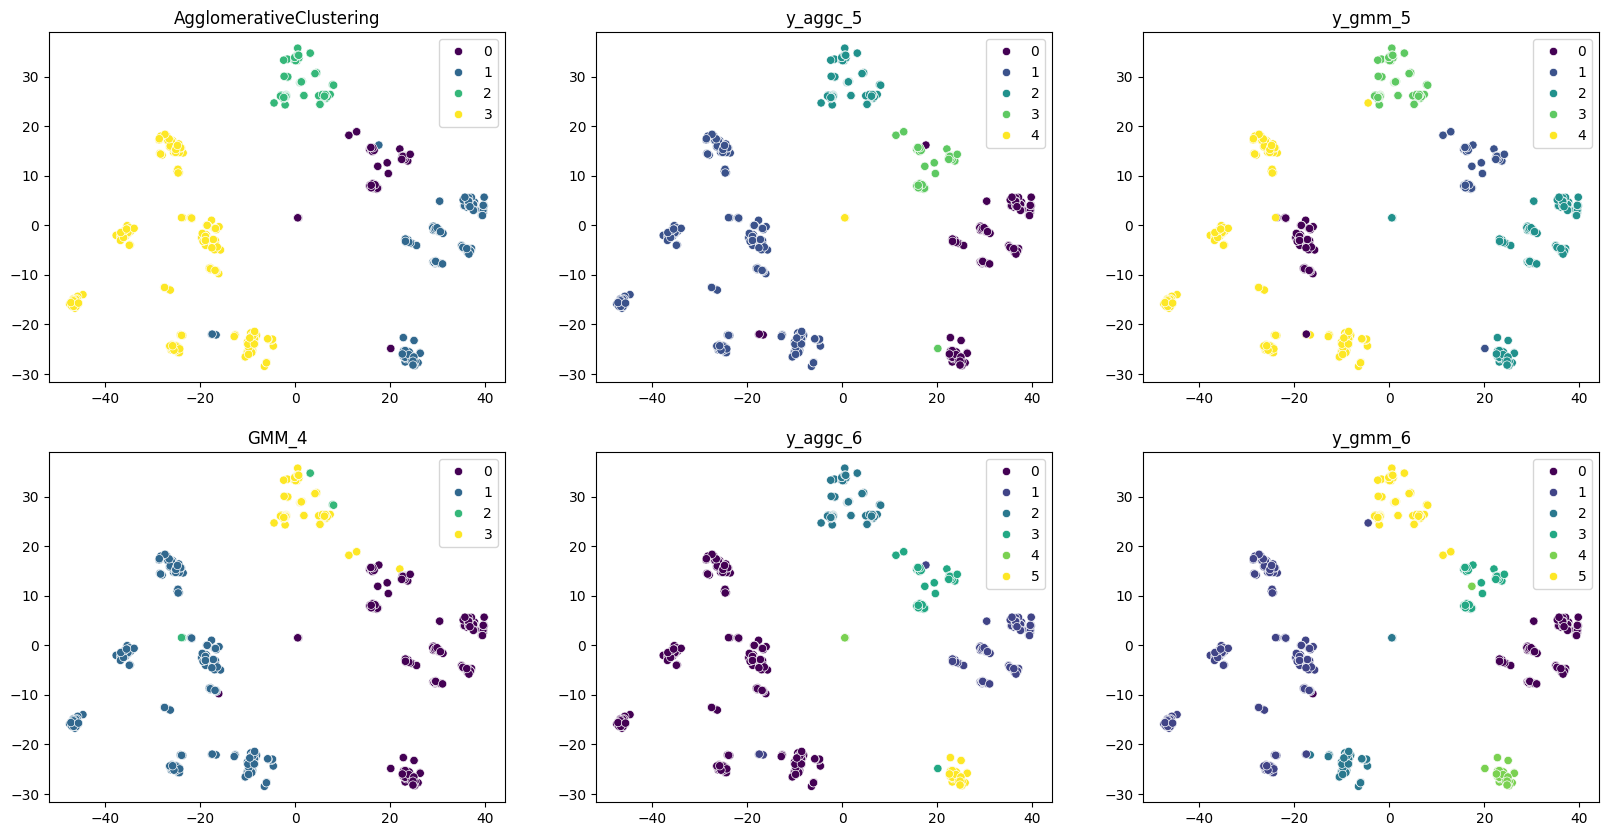

In [39]:
df2_copy = df2.copy()
tSNE = TSNE(random_state=60, verbose=1,n_iter=10000)
digits_proj = tSNE.fit_transform(df2_copy)

figure,ax = plt.subplots(2,3,figsize=(20,10))
ax = ax.flatten()
predictions = [y_aggc,y_aggc_5,y_gmm_5,y_gmm,y_aggc_6,y_gmm_6]
predictions_title = ['AgglomerativeClustering','y_aggc_5','y_gmm_5','GMM_4','y_aggc_6','y_gmm_6']
for i in range(len(predictions)):
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
    ax[i].set_title(predictions_title[i])
plt.show()

# Wykresy wyników PCA

In [68]:
#funkcja z labów
def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1],
                    c=palette[colors.astype(int)])
    # plt.xlim(-25, 25)
    # plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add labels
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txts.append(txt)

    return f, ax, sc, txts

c:\Users\jancw\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jancw\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


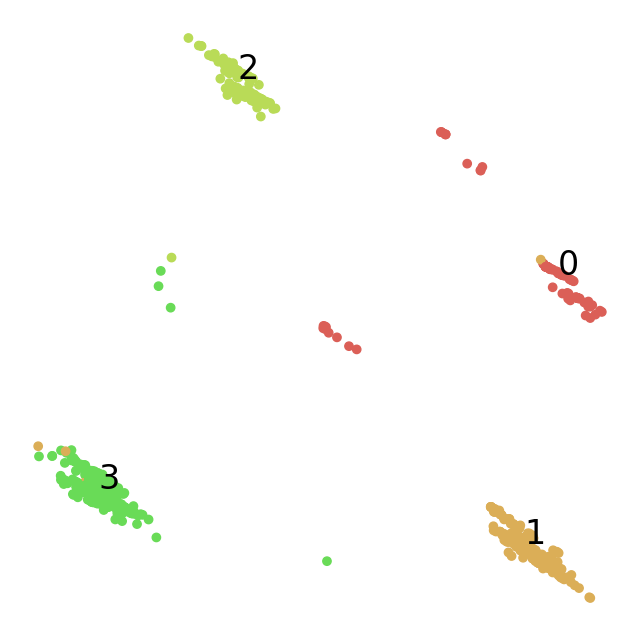

In [50]:
#używając samego PCA widoczne są 4 klastry i AgglomerativeClustering(4) sprawdza się najlepiej (perfekcyjnie wsm w porownaniu z kazdym innym)
pca = PCA(n_components = 2)
digits_proj_pca = pca.fit_transform(df2)
scatter(digits_proj_pca, y_aggc)
plt.show()

# PCA + TSNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.523968
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.793865
[t-SNE] KL divergence after 1000 iterations: 0.167923


c:\Users\jancw\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jancw\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


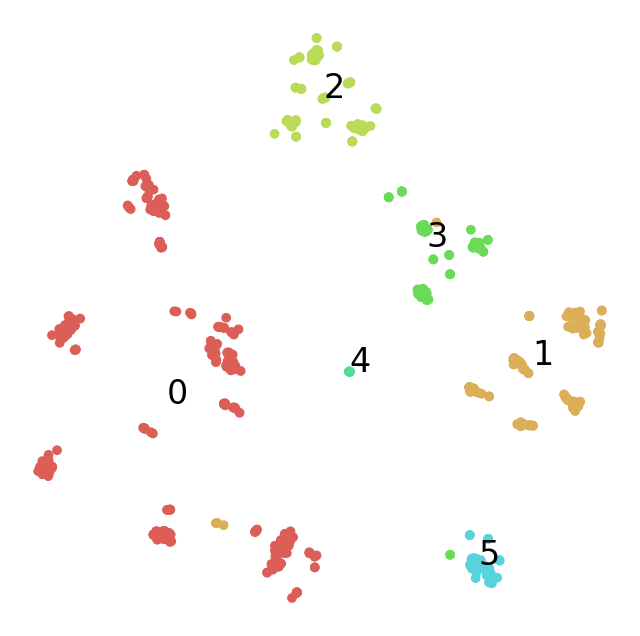

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


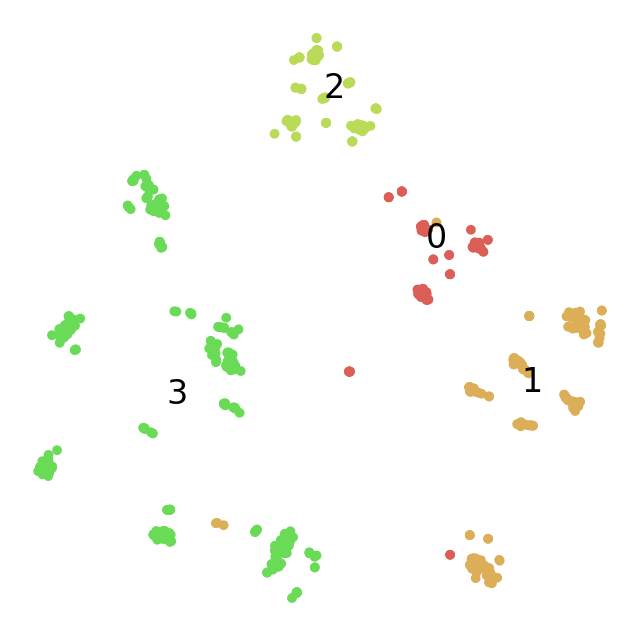

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


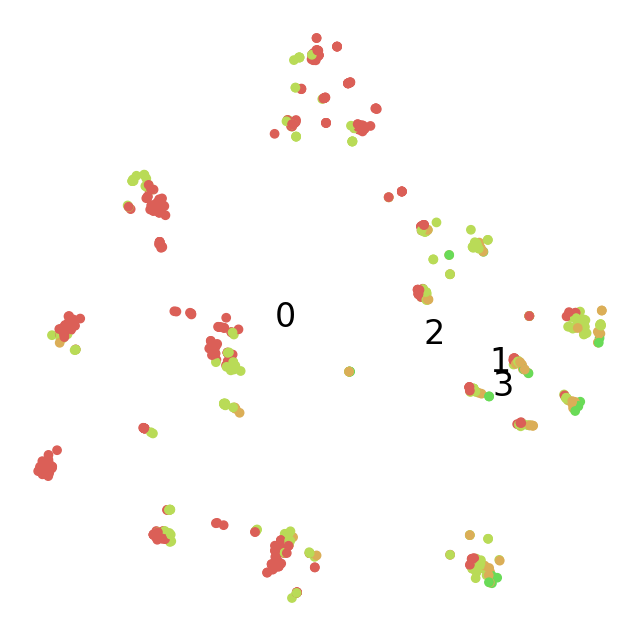

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


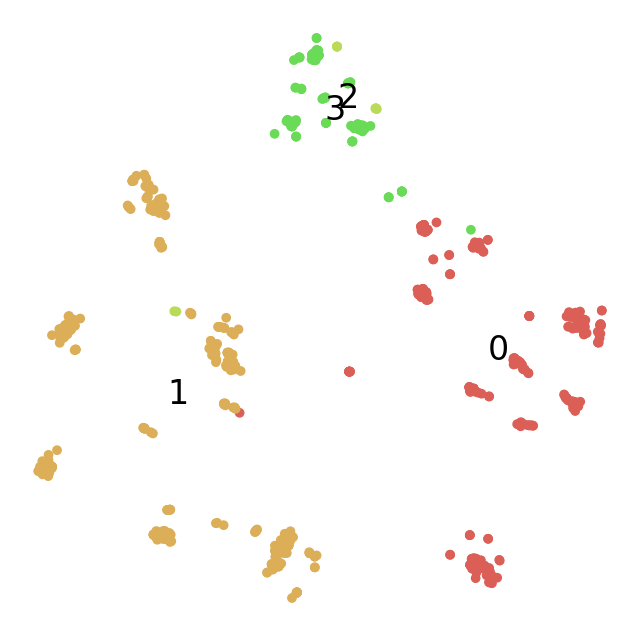

In [61]:
X_pca =  PCA(n_components=30).fit_transform(df2_copy)
digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
scatter(digits_proj, y_aggc_6)
scatter(digits_proj, y_aggc)
scatter(digits_proj, y_km)
scatter(digits_proj, y_gmm)

plt.show()

# Transformacje

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline

In [18]:
class MinMaxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,classes):
         self.scaler = [MinMaxScaler() for _ in range(len(classes))]
         self.classes = classes
         
    def fit(self, X, y=None):
            for i,col in enumerate(self.classes):
                self.scaler[i].fit(X[[col]])
            return self
    
    def transform(self, X, y=None):
        Xc = X.copy()
        for i,col in enumerate(self.classes):
             Xc[col] = self.scaler[i].transform(Xc[[col]])
        return Xc

In [19]:
class transformer_1(BaseEstimator, TransformerMixin):
    
    def fit(self,df,y= None):
        return self
    
    def transform(self,X,y= None):
    
        X_copy = X.copy()

        # Resolution correction
        mask = X_copy.resolution_width <= X_copy.resolution_height
        X_copy.loc[mask,["resolution_width","resolution_height"]] = X_copy.loc[mask,["resolution_height","resolution_width"]].values

        # Processor tier
        A = X_copy['processor_tier']
        A[A=='celeron'] = 'core i3'
        A[A=='pentium'] = 'core i5'
        A[A=='m1'] = 'core i5'
        A[A=='m2'] = 'core i7'
        mask_other_processor_tier = A=='other'
        A[A=='other'] = '0'
        A = A.apply(lambda x : 0 if len(re.findall(r'\d+', x))==0 else int(re.findall(r'\d+', x)[0]))
        X_copy['processor_tier'] = A
        X_copy['processor_type_other'] = mask_other_processor_tier + 0

        # One Hot Encoding
        diff1 = pd.get_dummies(X_copy[['processor_brand','OS','gpu_brand','gpu_type']],dtype='int')

        # OHEncoding brands
        brands_to_keep = ['hp' , 'lenovo' , 'asus','dell','msi','acer','apple']
        X_copy['brand'] = X_copy['brand'].apply(lambda x: x if x in brands_to_keep else 'other')
        diff2 = pd.get_dummies(X_copy[['brand']],dtype='int')
        X_copy = pd.concat([X_copy,diff1,diff2],axis=1)
        X_copy = X_copy.drop(['index','Model','brand','OS','processor_brand','gpu_brand','gpu_type'],axis=1)

        # Correcting types
        X_copy.is_touch_screen = X_copy.is_touch_screen + 0
        X_copy.primary_storage_type = (X_copy.primary_storage_type=='SSD') + 0

        # year_of_warranty
        mask_year_of_war_no =X_copy.year_of_warranty=='No information'
        X_copy.loc[mask_year_of_war_no,['year_of_warranty']] = 0
        X_copy['year_of_warranty'] = X_copy['year_of_warranty'].apply(lambda x : int(x))
        X_copy['year_of_warranty_other'] = mask_year_of_war_no + 0

        # secondary_storage_type drop
        X_copy = X_copy.drop('secondary_storage_type',axis=1)

        # other transformations 
        X_copy['primary_storage_capacity'] = np.log2(X_copy.primary_storage_capacity)
        X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
        X_copy['resolution_width']  = np.log(X_copy.resolution_width)
        X_copy['resolution_height'] = np.log(X_copy.resolution_height) 
        X_copy['Rating'] = X_copy['Rating']/100

        # for i,col in enumerate(self.classes):
        #     X_copy[col] = self.minmax[i].fit_transform(X_copy[[col]])
        

        return X_copy

In [20]:
class transformer_2(BaseEstimator, TransformerMixin):
    
    def fit(self,df,y= None):
        return self
    
    def transform(self,X,y= None):
    
        X_copy = X.copy()

        # Resolution correction
        mask = X_copy.resolution_width <= X_copy.resolution_height
        X_copy.loc[mask,["resolution_width","resolution_height"]] = X_copy.loc[mask,["resolution_height","resolution_width"]].values

        # Processor tier
        A = X_copy['processor_tier']
        A[A=='celeron'] = 'core i3'
        A[A=='pentium'] = 'core i5'
        A[A=='m1'] = 'core i5'
        A[A=='m2'] = 'core i7'
        mask_other_processor_tier = A=='other'
        A[A=='other'] = '0'
        A = A.apply(lambda x : 0 if len(re.findall(r'\d+', x))==0 else int(re.findall(r'\d+', x)[0]))
        X_copy['processor_tier'] = A
        X_copy['processor_type_other'] = mask_other_processor_tier + 0

        # One Hot Encoding
        diff1 = pd.get_dummies(X_copy[['processor_brand','OS','gpu_brand','gpu_type']],dtype='int')

        # OHEncoding brands
        brands_to_keep = ['hp' , 'lenovo' , 'asus','dell','msi','acer','apple']
        X_copy['brand'] = X_copy['brand'].apply(lambda x: x if x in brands_to_keep else 'other')
        diff2 = pd.get_dummies(X_copy[['brand']],dtype='int')
        X_copy = pd.concat([X_copy,diff1,diff2],axis=1)
        X_copy = X_copy.drop(['index','Model','brand','OS','processor_brand','gpu_brand','gpu_type'],axis=1)

        # Correcting types
        X_copy.is_touch_screen = X_copy.is_touch_screen + 0
        X_copy.primary_storage_type = (X_copy.primary_storage_type=='SSD') + 0

        # Price to log
        X_copy['Price'] = np.log(X_copy['Price'] )

        # year_of_warranty
        mask_year_of_war_no =X_copy.year_of_warranty=='No information'
        X_copy.loc[mask_year_of_war_no,['year_of_warranty']] = 0
        X_copy['year_of_warranty'] = X_copy['year_of_warranty'].apply(lambda x : int(x))
        X_copy['year_of_warranty_other'] = mask_year_of_war_no + 0

        # secondary_storage_type drop
        X_copy = X_copy.drop('secondary_storage_type',axis=1)

        # other transformations 
        X_copy['primary_storage_capacity'] = np.log2(X_copy.primary_storage_capacity)
        X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
        X_copy['resolution_width']  = np.log(X_copy.resolution_width)
        X_copy['resolution_height'] = np.log(X_copy.resolution_height) 
        X_copy['Rating'] = X_copy['Rating']/100

        # for i,col in enumerate(self.classes):
        #     X_copy[col] = self.minmax[i].fit_transform(X_copy[[col]])
        

        return X_copy

In [49]:
# classess = ['Price','resolution_width','resolution_height','display_size','processor_tier','num_cores','num_threads',
#             'ram_memory','primary_storage_capacity','secondary_storage_capacity']
# ppl = Pipeline([
#     ('transformer',transformer_1()),
#     ('minmax',MinMaxTransformer(classess))
# ])
# datatest = data.copy()
# xtes = ppl.fit_transform(datatest)

C:\Users\jancw\AppData\Local\Temp\ipykernel_16060\3961538699.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='celeron'] = 'core i3'
C:\Users\jancw\AppData\Local\Temp\ipykernel_16060\3961538699.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='pentium'] = 'core i5'
C:\Users\jancw\AppData\Local\Temp\ipykernel_16060\3961538699.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='m1'] = 'core i5'
C:\Users\jancw\App

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,secondary_storage_capacity,is_touch_screen,...,gpu_type_integrated,brand_acer,brand_apple,brand_asus,brand_dell,brand_hp,brand_lenovo,brand_msi,brand_other,year_of_warranty_other
0,0.070215,0.53,0.555556,0.181818,0.375,0.125,1,0.666667,0.0,0,...,1,0,0,0,0,0,0,1,0,0
1,0.242356,0.73,0.777778,0.545455,0.625,0.375,1,0.833333,0.0,0,...,0,0,0,0,0,0,0,1,0,0


# Diffrent tests

In [74]:
classess = ['Price','resolution_width','resolution_height','display_size','processor_tier','num_cores','num_threads',
            'ram_memory','primary_storage_capacity','secondary_storage_capacity']
ppl = Pipeline([
    ('transformer',transformer_2()),
    ('minmax',MinMaxTransformer(classess))
])
datatest = data.copy()
model_data = ppl.fit_transform(datatest)
model_matrix = model_data.values
model_aggc_7 = AgglomerativeClustering(n_clusters=7)
y_aggc_7 = model_aggc_7.fit_predict(model_matrix)

C:\Users\jancw\AppData\Local\Temp\ipykernel_16060\57213933.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='celeron'] = 'core i3'
C:\Users\jancw\AppData\Local\Temp\ipykernel_16060\57213933.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='pentium'] = 'core i5'
C:\Users\jancw\AppData\Local\Temp\ipykernel_16060\57213933.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='m1'] = 'core i5'
C:\Users\jancw\AppData\L

In [57]:
def tsne_plot(df,ys,r,c,predictions_title):
    df_copy = df.copy()
    tSNE = TSNE(random_state=60, verbose=1,n_iter=10000)
    digits_proj = tSNE.fit_transform(df_copy)

    figure,ax = plt.subplots(r,c,figsize=(20,10))
    ax = ax.flatten()
    predictions = ys
    predictions_title = predictions_title
    for i in range(len(predictions)):
        sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
        ax[i].set_title(predictions_title[i])
    plt.show()

C:\Users\jancw\AppData\Local\Temp\ipykernel_16060\912985032.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='celeron'] = 'core i3'
C:\Users\jancw\AppData\Local\Temp\ipykernel_16060\912985032.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='pentium'] = 'core i5'
C:\Users\jancw\AppData\Local\Temp\ipykernel_16060\912985032.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='m1'] = 'core i5'
C:\Users\jancw\AppDat

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.531447
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.878365
[t-SNE] KL divergence after 4150 iterations: 0.163157


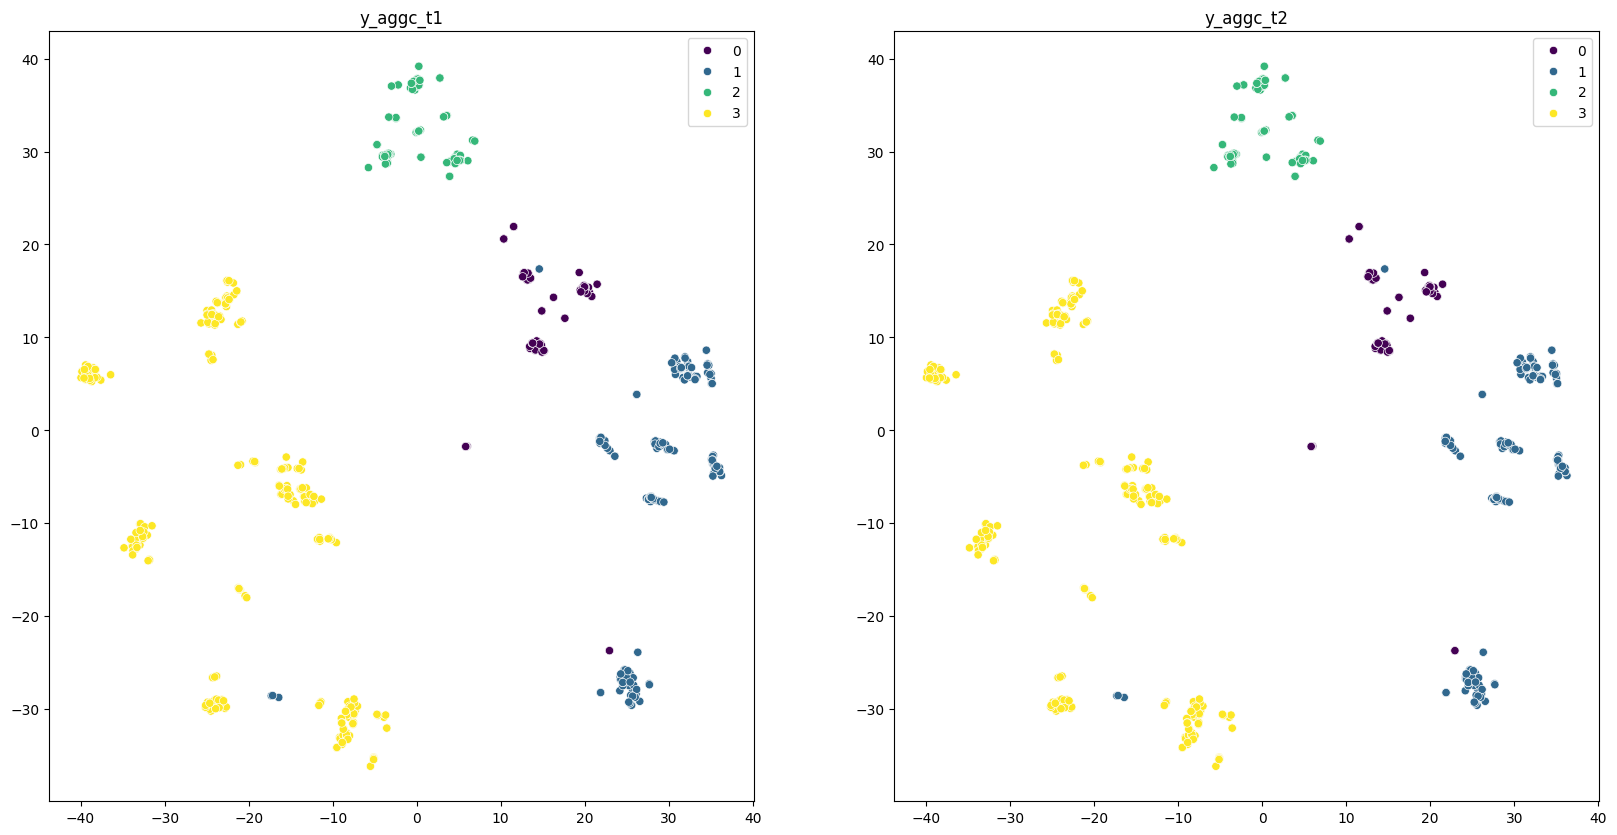

In [75]:
ppl1 = Pipeline([
    ('transformer',transformer_1()),
    ('minmax',MinMaxTransformer(classess))
])
ppl2 = Pipeline([
    ('transformer',transformer_2()),
    ('minmax',MinMaxTransformer(classess))
])

datatest = data.copy()
model_matrix1 = ppl1.fit_transform(datatest).values
model_matrix2 = ppl2.fit_transform(datatest).values

model_aggc_t1 = AgglomerativeClustering(n_clusters=4)
model_aggc_t2 = AgglomerativeClustering(n_clusters=4)

y_aggc_t1 = model_aggc_t1.fit_predict(model_matrix1)
y_aggc_t2 = model_aggc_t2.fit_predict(model_matrix2)

tsne_plot(model_data,[y_aggc_t1,y_aggc_t2],1,2,['y_aggc_t1','y_aggc_t2'])

# MODELE na różnych danych (transformacje)

In [44]:
from functools import partial

In [54]:
data_s = pd.read_csv("modelers_data_encoded_scaled.csv")

In [124]:
import warnings 
warnings.filterwarnings('ignore') 

In [164]:
def show_metrics(X,model):
    # input:
    # X = przetransformowany dataFrame
    # model = niewytrenowany model
    X = X.values
    y = model.fit_predict(X)
    silhouette = silhouette_score(X, y)
    db_index = davies_bouldin_score(X, y)
    ch_index = calinski_harabasz_score(X, y)

    # Print the metric scores
    # print(f"Silhouette Score: {silhouette:.2f}")
    # print(f"Davies-Bouldin Index: {db_index:.2f}")
    # print(f"Calinski-Harabasz Index: {ch_index:.2f}")      

    return([silhouette,db_index,ch_index])  

def wyniki(model1,model2,model3):
    # input: 3 niewytrenowane modele
    model_data = data_s.copy()
    w1 = show_metrics(model_data,model1)

    classess = ['Price','resolution_width','resolution_height','display_size','processor_tier','num_cores','num_threads',
            'ram_memory','primary_storage_capacity','secondary_storage_capacity']
    ppl = Pipeline([
        ('transformer',transformer_1()),
        ('minmax',MinMaxTransformer(classess))
    ])
    datatest = data.copy()
    model_data = ppl.fit_transform(datatest)
    w2 = show_metrics(model_data,model2)

    ppl = Pipeline([
    ('transformer',transformer_2()),
    ('minmax',MinMaxTransformer(classess))
    ])
    datatest = data.copy()
    model_data = ppl.fit_transform(datatest)
    w3 = show_metrics(model_data,model3)

    df = pd.DataFrame({
        "metric" : ["silhouette","davies_bouldin","calinski_harabasz"],
        "data_s" : w1,
        "transformer_1" : w2,
        "transformer_2" : w3
    })

    df.set_index('metric',inplace=True)
    
    return df

# GaussianMixture

In [174]:
m = mixture.GaussianMixture(n_components=4, covariance_type="full")
wyniki(m,m,m)

,data_s,transformer_1,transformer_2
metric,,,
silhouette,0.228124,0.238290,0.330041
davies_bouldin,1.724362,1.391497,1.377543
calinski_harabasz,138.412742,208.618886,231.651910


# DBSCAN

In [177]:
model_dbscan = DBSCAN(eps=1.41,min_samples=7)
wyniki(model_dbscan,model_dbscan,model_dbscan)


,data_s,transformer_1,transformer_2
metric,,,
silhouette,0.370784,0.512675,0.509123
davies_bouldin,1.268553,1.365860,1.368605
calinski_harabasz,37.385773,100.574854,100.165941


# Hiperparam

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.787692
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.392288
[t-SNE] KL divergence after 4900 iterations: 0.242743


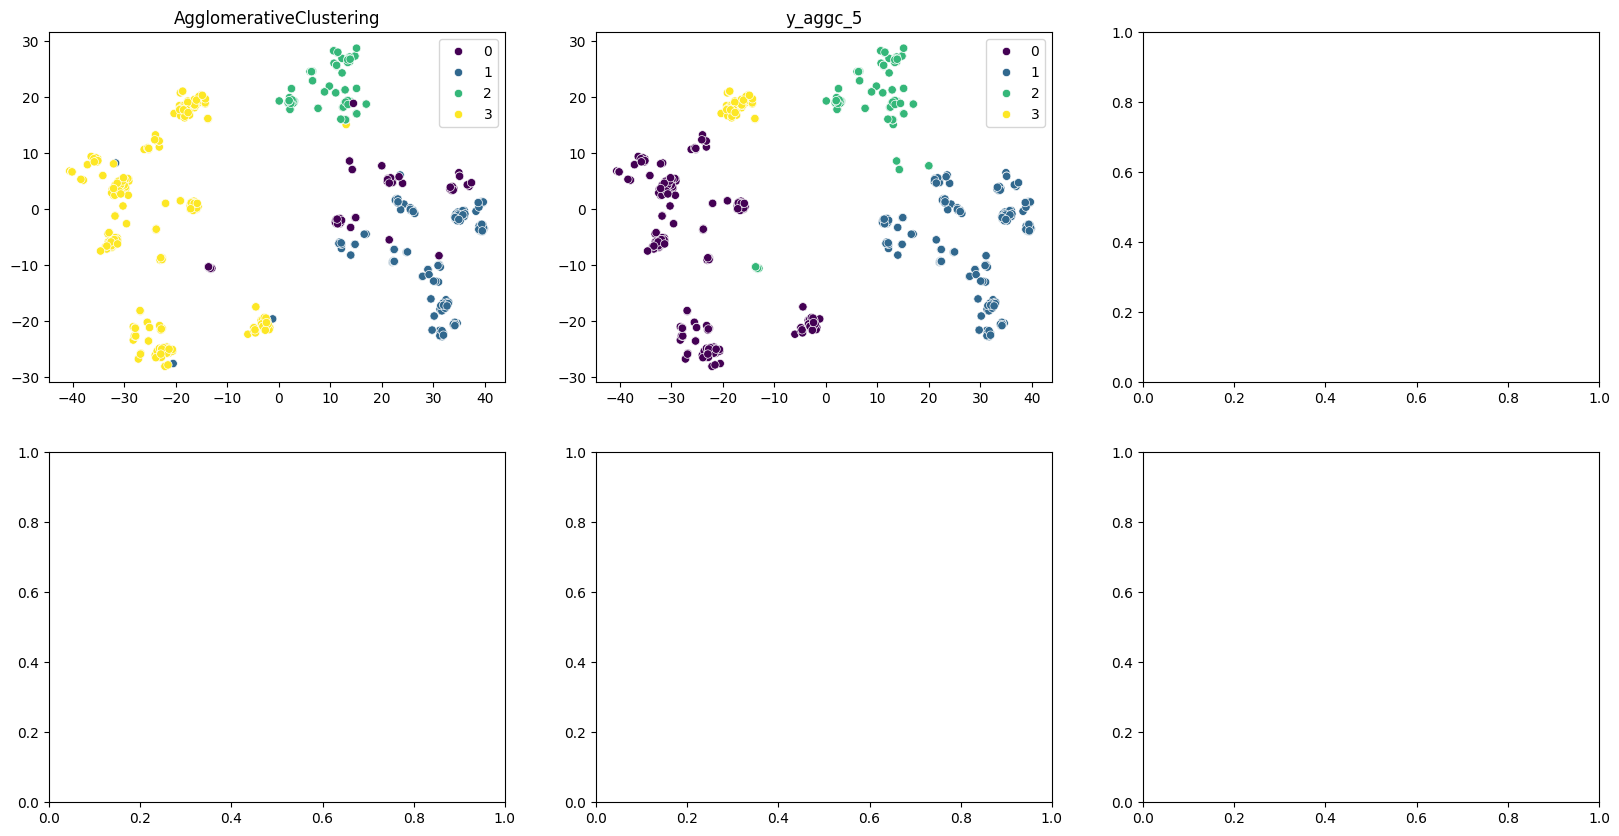

In [59]:
# tSNE = TSNE(random_state=60, verbose=1,n_iter=10000)
# digits_proj = tSNE.fit_transform(data_s)

# figure,ax = plt.subplots(2,3,figsize=(20,10))
# ax = ax.flatten()
# predictions = [y_aggc,y_aggc_s]
# predictions_title = ['AgglomerativeClustering','y_aggc_5']
# for i in range(len(predictions)):
#     sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
#     ax[i].set_title(predictions_title[i])
# plt.show()